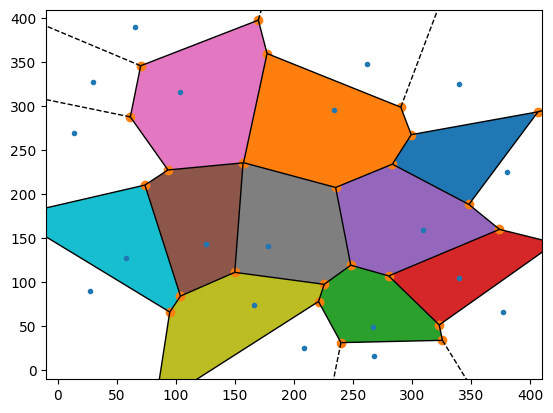

In [27]:
from generativepy.drawing import make_image, setup
from generativepy.geometry import Circle, Polygon
from generativepy.color import Color
from scipy.spatial import Voronoi, voronoi_plot_2d
import random
import numpy as np
import matplotlib.pyplot as plt

SIZE = 400
POINTS = 20
BOUND_FACTOR = 100

# Create a list of random points
random.seed(40)
points = [[random.randrange(SIZE), random.randrange(SIZE)]
          for i in range(POINTS)]

voronoi = Voronoi(points)
voronoi_plot_2d(voronoi),

# colorize
for region in voronoi.regions:
    if not -1 in region:
        polygon = [voronoi.vertices[i] for i in region]
        plt.fill(*zip(*polygon))

# # fix the range of axes
plt.xlim([-10,SIZE + 10]), plt.ylim([-10, SIZE + 10])

plt.show()

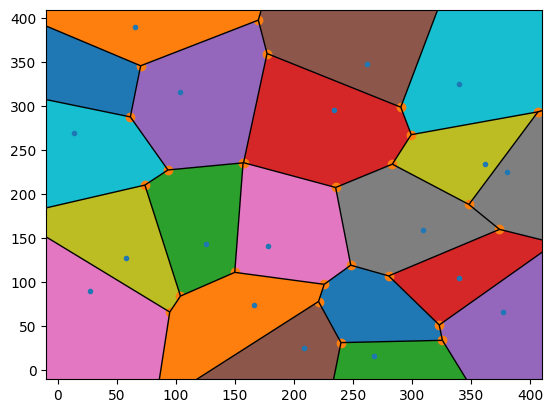

In [28]:
points.append((-SIZE*BOUND_FACTOR, -SIZE*BOUND_FACTOR))
points.append((-SIZE*BOUND_FACTOR, SIZE*BOUND_FACTOR))
points.append((SIZE*BOUND_FACTOR, -SIZE*BOUND_FACTOR))
points.append((SIZE*BOUND_FACTOR, SIZE*BOUND_FACTOR))

voronoi = Voronoi(points)
voronoi_plot_2d(voronoi),

# colorize
for region in voronoi.regions:
    if not -1 in region:
        polygon = [voronoi.vertices[i] for i in region]
        plt.fill(*zip(*polygon))

# fix the range of axes
plt.xlim([-10,SIZE + 10]), plt.ylim([-10, SIZE + 10])

plt.show()

In [29]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp(axis=0).max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

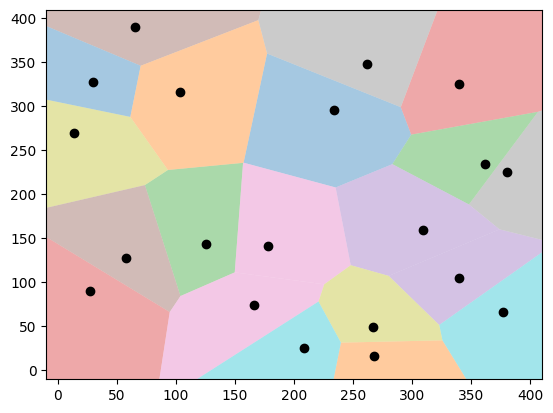

In [36]:
# make up data points
points_np = np.array(points)

# compute Voronoi tesselation
vor = Voronoi(points_np)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points_np[:,0], points_np[:,1], 'ko')
# fix the range of axes
plt.xlim([-10,SIZE + 10]), plt.ylim([-10, SIZE + 10])

plt.show()